# __Sistema de clasificación__

__CIMAT: Maestría en Cómputo Estadístico__
             
__Instituto de Investigaciones Jurídicas. UNAM.__ 


El siguiente nootebook hace una implemtación de un modelo BERT para la calsifiacion de los tipos diferentes de recomendaciones Realizadas por los diferentes órganos de las Naciones Unidas. 


_Contenido_: 
- Qué datos tenemos?
- Modelos
- Un modelo tradicional
- Recomendaciones

### Análisi Exploratorio

In [1]:
import os 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl            
plt.style.use("ggplot")

mpl.rcParams.update({
    "font.family"      : "serif",
    "font.serif"       : ["Times New Roman"], 
    "text.color"       : "black",
    "axes.labelcolor"  : "black",
    "axes.titlecolor"  : "black",
    "xtick.color"      : "black",
    "ytick.color"      : "black",
    "axes.edgecolor"   : "black",             
})


In [2]:
df = pd.read_excel('./data_clasif/2105 Recos y respuestas .xlsx')

In [3]:
print("Forma:",df.shape)
df.head()

Forma: (1907, 8)


,Órgano de NU,Tipo de documento,Símbolo/Título,Texto recomendación,Tipo de recomendación,Respuesta del estado a la recomendación A,Tipo de documento A,Tipo de respuesta
0,CAT,Concluding observations,CAT/C/ALB/CO/2,13. The Committee recommends that the State pa...,NaN,107.With the amendments made in 2017 to the Cr...,State party's report,Cumplimiento
1,CED,Concludding observations,CED/C/ESP/CO/1,The Committee recalls that the search for pers...,Reforma legislación,"At the start of 2012, the Department of Right...",Follow up report,Ejecucción
2,CED,Concludding observations,CED/C/ESP/CO/1,The Committee recommends that the State party ...,Otro,In cases in which the law provides for incomm...,Follow up report,Inacción
3,CED,Concludding observations,CED/C/ESP/CO/1,The Committee encourages the State party to en...,Otro,"In Spain, generally speaking, if there are in...",Additional Information,Ejecucción
4,CAT,Concludding observations,CAT/C/ARG/CO/5-6,Parrafo 24 El Estado parte debe garantizar:\na...,Reforma institutución,\nNo mencion.,State party's report,No mención


In [4]:
print(df.columns.tolist())

['Órgano de NU', 'Tipo de documento', 'Símbolo/Título', 'Texto recomendación', 'Tipo de recomendación', 'Respuesta del estado a la recomendación A', 'Tipo de documento A', 'Tipo de respuesta']


In [5]:
instituciones = df['Órgano de NU'].unique().tolist()
print(f'Número de Órgano de NU: {len(instituciones)}\n')
print(f'{instituciones}')

Número de Órgano de NU: 7

['CAT', 'CED', 'CEDAW', 'UN Special Rapporteur on Torture and Other Cruel, Inhuman or Degrading Treatment or Punishment', 'WGEID', '                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [6]:
df['Órgano de NU'] = df['Órgano de NU'].astype(str).str.strip().replace({'nan': None, '': None, r'^\s+$': None}, regex=True).fillna('Sin especificar')

freq = df.groupby('Órgano de NU', dropna=False)['Texto recomendación'].count().sort_values(ascending=False)
print(freq.to_string())

Órgano de NU
CAT                                                                                               971
CED                                                                                               573
WGEID                                                                                             196
UN Special Rapporteur on Torture and Other Cruel, Inhuman or Degrading Treatment or Punishment    134
CEDAW                                                                                              10
Sin especificar                                                                                     5


In [7]:
nan_counts = df['Texto recomendación'].isna().groupby(df['Órgano de NU']).sum().astype(int).reindex(freq.index)  
print(nan_counts.to_string(dtype=False))

Órgano de NU
CAT                                                                                               18
CED                                                                                                0
WGEID                                                                                              0
UN Special Rapporteur on Torture and Other Cruel, Inhuman or Degrading Treatment or Punishment     0
CEDAW                                                                                              0
Sin especificar                                                                                    0


In [8]:
def get_nan_idx(df: pd.DataFrame, col: str) -> list[int]:
    return df.index[df[col].isna()].tolist()
nan_idx = get_nan_idx(df, 'Texto recomendación')
print(nan_idx)

[1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]


In [9]:
df.iloc[1892]

Órgano de NU                                                     CAT
Tipo de documento                            Concluding observations
Símbolo/Título                                        CAT/C/ARM/CO/3
Texto recomendación                                              NaN
Tipo de recomendación                                            NaN
Respuesta del estado a la recomendación A                        NaN
Tipo de documento A                                              NaN
Tipo de respuesta                                                NaN
Name: 1892, dtype: object

__Texto de las Recomendaciones__

In [10]:
columns_name = ['Órgano de NU', 'Texto recomendación', 'Tipo de recomendación']
new_names = ['organo', 'texto', 'tipo']

In [11]:
df_recomendacion = df.loc[:,columns_name].rename(columns=dict(zip(columns_name,new_names))).copy()

In [12]:
df_recomendacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907 entries, 0 to 1906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   organo  1907 non-null   object
 1   texto   1889 non-null   object
 2   tipo    1024 non-null   object
dtypes: object(3)
memory usage: 44.8+ KB


In [13]:
len(df_recomendacion['tipo'].unique())

16

In [14]:
df_recomendacion['tipo'].value_counts()

tipo
Otro                      601
Reforma legislación       152
Nueva herramienta         106
Nueva legislación          65
Reforma institución        31
Reforma herramienta        29
Nueva institución          21
Reforma institutución       5
Reforma herramienta         4
Nueva herramienta           3
Nueva institutución         2
Otra                        2
Nueva dependecia            1
Nueva institucion           1
Reforma institutución       1
Name: count, dtype: int64

In [15]:
map_tipo = {
    'Otro':                     'otro',
    'Otra':                     'otro',
    'Reforma legislación':      'legislacion',
    'Nueva legislación':        'legislacion',
    'Reforma herramienta':      'herramienta',
    'Nueva herramienta':        'herramienta',
    'Reforma institución':      'institucion',
    'Nueva institución':        'institucion',
    'Reforma institutución':    'institucion',
    'Nueva institutución':      'institucion',
    'Nueva institucion':        'institucion',   
    'Reforma institutución ':   'institucion',   
    'Nueva dependecia':         'institucion',  
}

In [16]:
df_recomendacion['tipo'] = df_recomendacion['tipo'].str.strip().replace(map_tipo)

<Axes: ylabel='Frequency'>

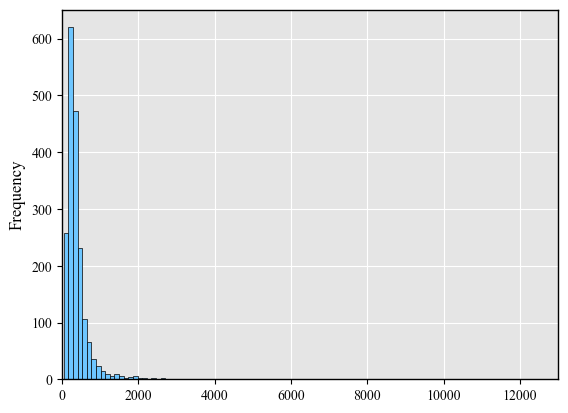

In [17]:
df_recomendacion['texto'].str.len().plot.hist(bins=100, xlim=(0, 13000),color="#6EC6FF",edgecolor='black')

Recomendaciones No etiquetados 

In [18]:
nan_idx = get_nan_idx(df_recomendacion, 'tipo')
print(f"No etiquetados: {len(nan_idx)}")

No etiquetados: 883


Documento más largo

In [19]:
idx_max = df_recomendacion['texto'].str.len().idxmax()
print('Indice: ',idx_max)
print(f"Tamaño: {len(df_recomendacion['texto'][idx_max])}")

Indice:  1851
Tamaño: 12129


Distribución de longitud de texto por tipo de recomendación: 

```['legislacion', 'otro', 'institucion', 'herramienta']```

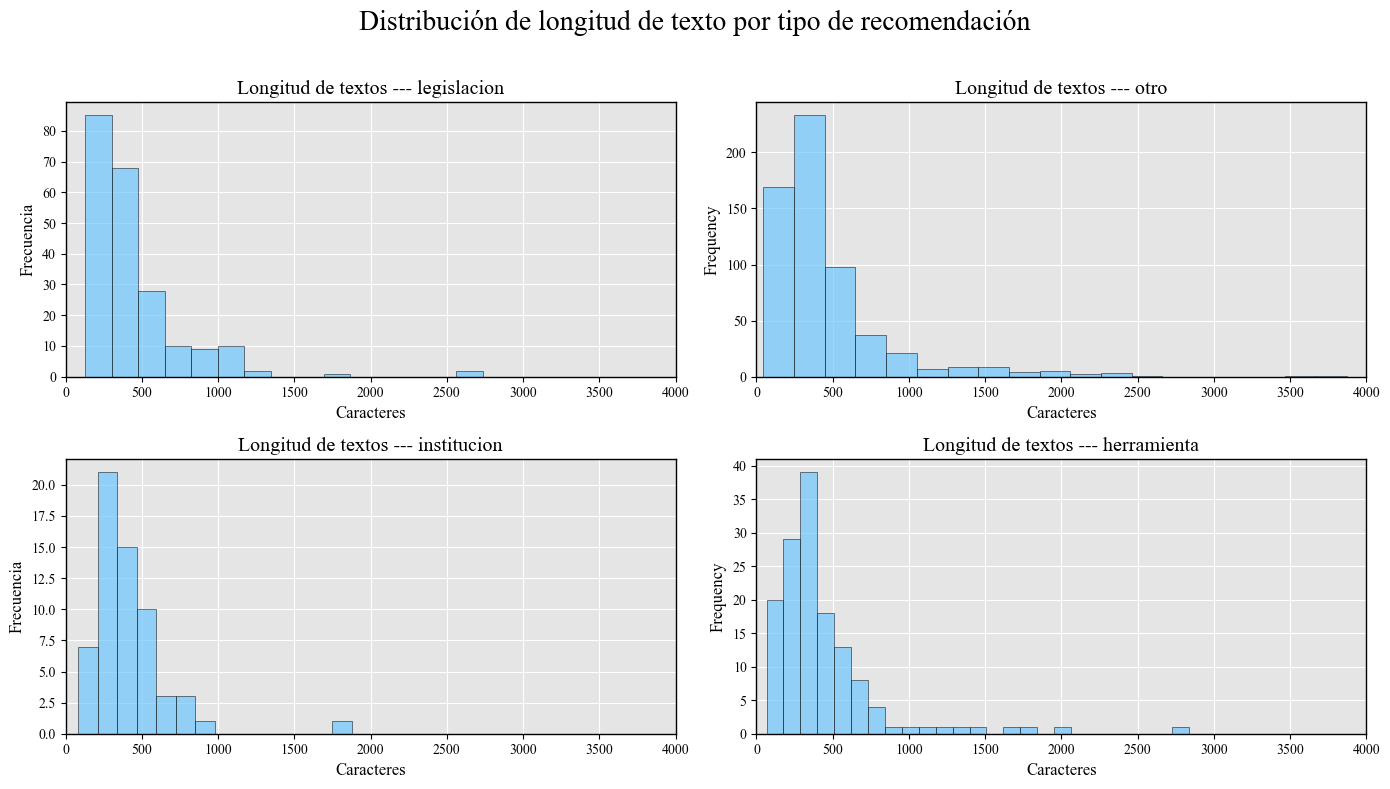

In [20]:
df_ok = df_recomendacion.dropna(subset=['tipo']).copy()
cats  = ['legislacion', 'otro', 'institucion', 'herramienta']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, cat in zip(axes.ravel(), cats):
    df_ok.loc[df_ok['tipo'] == cat, 'texto'].str.len().plot.hist(ax=ax, bins=60, xlim=(0, 4000), alpha=0.7, color="#6EC6FF", edgecolor='black')

    ax.set_title(f'Longitud de textos --- {cat}')
    ax.set_xlabel('Caracteres')
    
    if cat in ('legislacion', 'institucion'):
        ax.set_ylabel('Frecuencia')

fig.suptitle('Distribución de longitud de texto por tipo de recomendación\n',fontsize=20)
plt.tight_layout()
plt.show()

Estadísticas Básicas

In [21]:
organs = df_ok['organo'].unique().tolist()
stats_by_type = df_ok['texto'].str.len().groupby(df_ok['tipo']).describe()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].reindex(cats)
print("\n=== Estadísticas de longitud textual por Tipo de recomendación ===")
stats_by_type


=== Estadísticas de longitud textual por Tipo de recomendación ===


,count,mean,std,min,25%,50%,75%,max
tipo,,,,,,,,
legislacion,217.0,532.640553,966.876811,126.0,249.0,346.0,507.00,10567.0
otro,603.0,506.212272,762.142483,45.0,235.5,341.0,512.50,12129.0
institucion,62.0,526.548387,968.632172,80.0,278.5,352.5,497.50,7785.0
herramienta,142.0,480.225352,645.309760,66.0,237.0,331.5,518.75,6724.0


__Limpieza__ 

Para garantizar un mejor procesamiento, limpiamos los textos utilizando `clean_text`

| | Acción                                                   | Propósito                                                                                           |
|------|----------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **1** | Reemplaza `\n` por un espacio                           | Unifica el texto en una sola línea.                                                                  |
| **2** | Elimina URLs (`http(s)://…`, `www.…`)                   | Quita enlaces irrelevantes para el análisis.                                                         |
| **3** | Normaliza Unicode con **NFKC**                          | Homogeneiza caracteres equivalentes (acentos, ligaduras).                          |
| **4** | Filtra puntuación y símbolos (`_PUNCT_RE`)              | Conserva letras, números y tildes españolas (`áéíóúñü`).                                             |
| **5** | Colapsa espacios múltiples (`\s+`)                      | Deja un único espacio entre palabras y recorta bordes.                                               |
| **6** | Convierte a **minúsculas**                              | Estandariza el texto para tokenización o modelado.                       


In [22]:
import re
import unicodedata

_URL_RE   = re.compile(r'https?://\S+|www\.\S+', flags=re.I)
_PUNCT_RE = re.compile(r'[^\w\sáéíóúñüÁÉÍÓÚÑÜ0-9]')  

def clean_text(text: str) -> str:
    text = text.replace('\n', ' ')
    text = _URL_RE.sub('', text)
    text = unicodedata.normalize('NFKC', text)  
    text = _PUNCT_RE.sub('', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

In [23]:
df_reco = df_recomendacion.dropna().reset_index(drop=True)
df_reco['texto'] = df_reco['texto'].apply(clean_text)
df_reco

,organo,texto,tipo
0,CED,the committee recalls that the search for pers...,legislacion
1,CED,the committee recommends that the state party ...,otro
2,CED,the committee encourages the state party to en...,otro
3,CAT,parrafo 24 el estado parte debe garantizar a q...,institucion
4,CED,the committee recommends that the state party ...,otro
...,...,...,...
1019,CED,33 b to swiftly search for and identify disapp...,otro
1020,CAT,12 the state party should take effective steps...,otro
1021,CAT,15 the state party should review its legislati...,otro
1022,CAT,11 the committee urges the state party to modi...,institucion


#### __Palabras más relevantes__


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2        
from wordcloud import WordCloud  

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words_en = text.ENGLISH_STOP_WORDS
stop_words_es = set(stopwords.words("spanish"))
STOPWORDS = list(stop_words_en | stop_words_es)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ericl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
tfidf = TfidfVectorizer(lowercase=True, stop_words=STOPWORDS, ngram_range=(1, 1), min_df=2)
X = tfidf.fit_transform(df_reco["texto"])
feature_names = np.array(tfidf.get_feature_names_out())

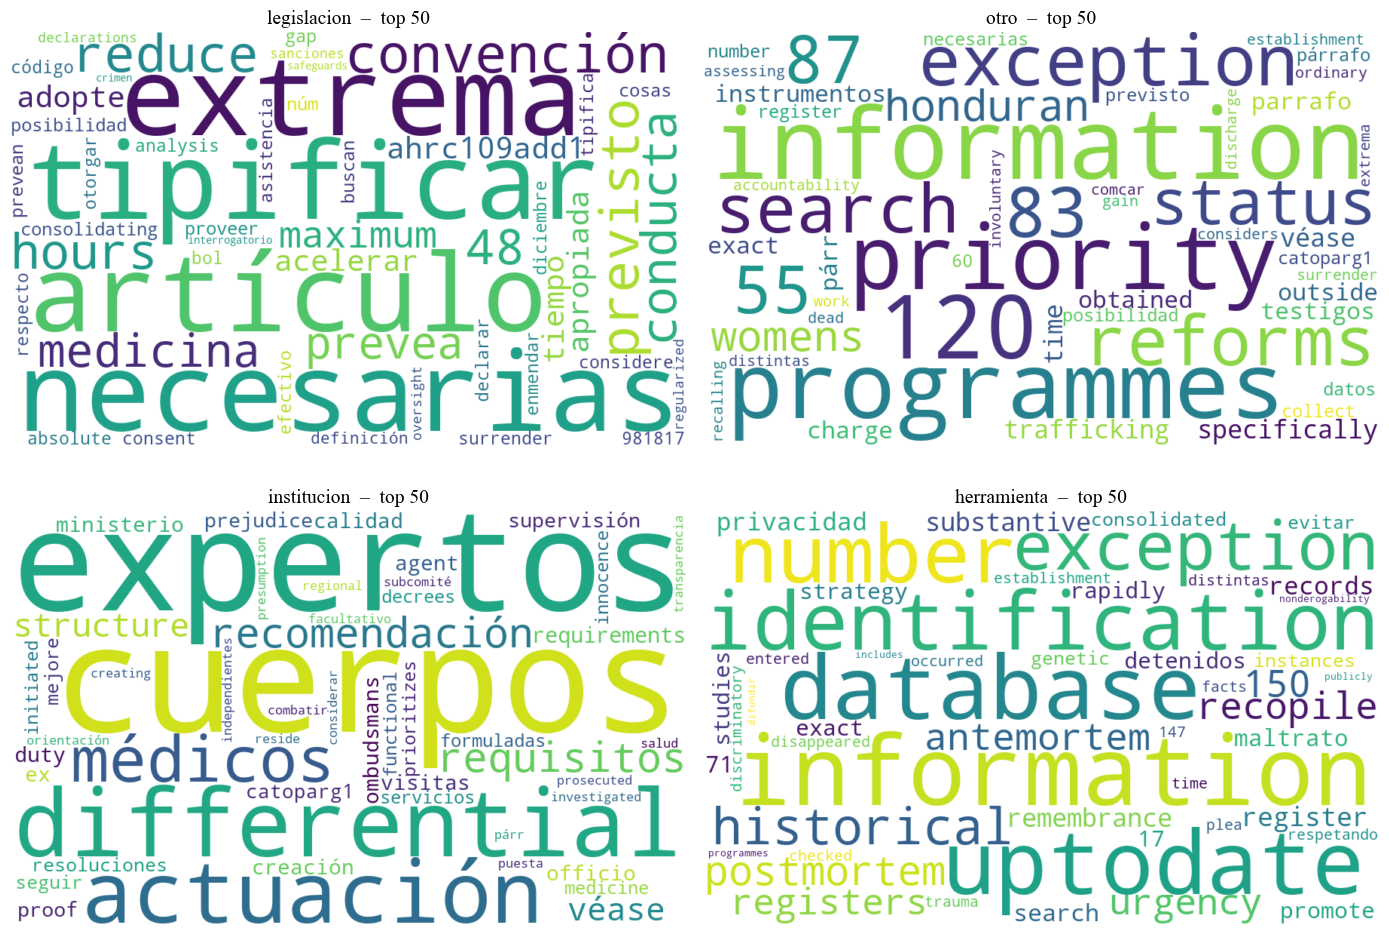

In [72]:
k = 50                           

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, label in zip(axes, df_reco['tipo'].unique().tolist()):
    # Clasificación binaria: etiqueta vs. resto
    y_bin = (df_reco["tipo"] == label).astype(int)
    chi_scores, _ = chi2(X, y_bin)
    
    # top-k índices y diccionario {palabra: score}
    top_idx = np.argsort(chi_scores)[-k:]
    freqs   = {feature_names[i]: chi_scores[i] for i in top_idx}
    
    wc = WordCloud(width=900,height=550,background_color="white",max_words=k).generate_from_frequencies(freqs)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"{label}  –  top {k}", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

__Particion de los datos__

In [24]:
from sklearn.model_selection import train_test_split

SEED = 7

X_train, X_test, y_train, y_test = train_test_split(
    df_reco['texto'],               
    df_reco['tipo'],                
    test_size=0.20,                 
    stratify=df_reco['tipo'],       
    random_state=SEED )


## Proprocesamiento

En esta sección hacemos un procesamiento de los textos de las recomendaciones y sus respectivas etiquetas para poder prepararlos para entrenar un modelo de deep learning. 

El modelo de deep learning que vamos a utilizar es modelo BERT multilingual preentrenado en varios idiomas dada a la diversidad de los textos. El modelo utilizado es `name_model = 'distilbert-base-multilingual-cased'`. 


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

def preprocessing(X_train, model_checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    return tokenizer(X_train.tolist(),padding=True,truncation=True,max_length=512,return_tensors="pt")

In [28]:
# print(X_train.shape) #(819,)
# print(type(X_train[0])) #<class 'str'>

# label2id = {lbl: idx for idx, lbl in enumerate(le.classes_)}
# id2label = {idx: lbl for lbl, idx in label2id.items()}

In [36]:
import torch 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def build_tensor_dataset(X_split, y_split,
                         model_checkpoint: str = "distilbert-base-multilingual-cased",
                         label_encoder: LabelEncoder | None = None):

    if label_encoder is None:
        label_encoder = LabelEncoder().fit(y_split)
    
    y_enc = torch.tensor(label_encoder.transform(y_split), dtype=torch.long)
    encodings = preprocessing(X_split, model_checkpoint)
    dataset = TensorDataset(encodings["input_ids"],encodings["attention_mask"],y_enc)

    return dataset, label_encoder

In [48]:
model_checkpoint = "distilbert-base-multilingual-cased"
train_ds, le = build_tensor_dataset(X_train, y_train, model_checkpoint)
val_ds, _ = build_tensor_dataset(X_test, y_test, model_checkpoint)

In [212]:
# X_test.shape

In [193]:
label2id = {lbl: idx for idx, lbl in enumerate(le.classes_)}
id2label = {idx: lbl for lbl, idx in label2id.items()}

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16 
train_dataloader = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=batch_size)
validation_dataloader = DataLoader(val_ds, sampler=SequentialSampler(val_ds), batch_size=batch_size)

In [32]:
batch = next(iter(train_dataloader))
batch

[tensor([[  101, 12180, 10684,  ...,     0,     0,     0],
         [  101,   172, 24457,  ...,     0,     0,     0],
         [  101,   170, 40781,  ...,     0,     0,     0],
         ...,
         [  101, 14519, 10312,  ...,     0,     0,     0],
         [  101, 53374, 10111,  ...,     0,     0,     0],
         [  101, 10105, 27634,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 1])]

## __Modelo__

In [33]:
from torch import nn
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import AutoModel, AutoTokenizer, AutoConfig

class BERTForRecomendationClasification(nn.Module): 
    def __init__(self, model_ckpt, num_labels ):
        """
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(BERTForRecomendationClasification, self).__init__()
        config = AutoConfig.from_pretrained( model_ckpt,
                                             output_hidden_states=False,
                                             output_attentions=False )
        self.num_labels = num_labels
        self.BERT = AutoModel.from_pretrained(model_ckpt, config=config )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids = None, attention_mask=None, labels = None):

        outputs = self.BERT(input_ids = input_ids, attention_mask = attention_mask  )
        
        last_hidden_state = outputs[0]

        sequence_outputs = self.dropout(last_hidden_state)

        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))
        
        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))
            
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)
        

### __Hiperparámetros__

In [49]:
from transformers import  get_scheduler
from torch.optim import AdamW  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BERTForRecomendationClasification(model_ckpt=model_checkpoint, num_labels=4).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-08)

num_epoch = 10
num_training_steps = num_epoch * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)


Función para evaluar (únicamente utilizamos el accuracy)

In [50]:
def eval_model(model, dataloader, device):
    model.eval()
    losses = []
    pred_list = []
    labels_list = []
    
    val_accuracy, val_precision, val_recall, val_specificity = [], [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            
            torch.cuda.empty_cache()

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels) 
            logits = outputs.logits
            losses.append(outputs.loss.item())

            preds = torch.argmax(logits, dim=-1)
            pred_list.extend(preds.cpu().tolist())
            labels_list.extend(b_labels.cpu().tolist())
            
    acc = np.mean(np.array(pred_list) == np.array(labels_list))
    return acc

In [259]:
from tqdm.auto import tqdm
import numpy as np 

train_loss_history = []
val_loss_history = []
best_val_acc = 0
tr_loss, nb_tr_examples, nb_tr_steps = 0, 0, 0

for epoch in range(num_epoch):
    model.train()
    chunk_batch = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epoch} - Training")
    for batch in chunk_batch:
        torch.cuda.empty_cache()
        
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)       
        loss = outputs.loss  
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        chunk_batch.set_postfix(train_loss=loss.item())

  
    acc_train = eval_model(model, train_dataloader, DEVICE)
    acc_val = eval_model(model, validation_dataloader, DEVICE)
    print(f"Epoch {epoch + 1}/{num_epoch} " f"train_acc: {acc_train:.4f} | " f"val_acc: {acc_val:.4f}")
  

Epoch 1/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/6 train_acc: 0.5885 | val_acc: 0.5902


Epoch 2/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/6 train_acc: 0.5910 | val_acc: 0.5951


Epoch 3/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/6 train_acc: 0.6459 | val_acc: 0.6098


Epoch 4/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/6 train_acc: 0.7717 | val_acc: 0.5951


Epoch 5/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/6 train_acc: 0.8938 | val_acc: 0.5659


Epoch 6/6 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/6 train_acc: 0.9219 | val_acc: 0.5707


### Entrenamiento

Aquí consideramos la métrica $F_1$ ya que contamos con datos debalanceados ya que es la media armónica de precisión y recall.   

In [46]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import f1_score

def eval_model(model, dataloader, device):
    model.eval()
    pred_list, labels_list = [], []
    losses = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            torch.cuda.empty_cache()
            batch = tuple(t.to(DEVICE) for t in batch)
            ids, mask, labels = batch
            
            outputs = model(ids, attention_mask=mask, labels=labels)            
            
            # Forward + loss + backward + step
            logits = outputs.logits
            loss   = outputs.loss
            losses.append(loss.item())

            preds = torch.argmax(logits, dim=-1)
            pred_list.extend(preds.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

    acc      = np.mean(np.array(pred_list) == np.array(labels_list))
    f1       = f1_score(labels_list, pred_list, average="macro")

    return  np.mean(losses), acc, f1

In [45]:
patience   = 3      # épocas sin mejora permitidas
min_delta  = 1e-4   # mejora mínima 
best_val_f1   = -np.inf 
wait       = 0      

train_loss_history = []
val_loss_history = []
best_val_acc = 0
tr_loss = 0

for epoch in range(num_epoch):
    model.train()
    chunk_batch = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epoch} - Training")
    for batch in chunk_batch:
        torch.cuda.empty_cache()
        batch = tuple(t.to(DEVICE) for t in batch)
        ids, mask, labels = batch

        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask, labels=labels)
        loss    = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    
        tr_loss += loss.item()    
        chunk_batch.set_postfix(train_loss=loss.item())

    
    train_loss, train_acc, train_f1 = eval_model(model, train_dataloader, DEVICE)
    val_loss,  val_acc,  val_f1     = eval_model(model, validation_dataloader, DEVICE)

    print(f"Epoch {epoch+1}/{num_epoch} | "
          f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | "
          f"train_acc:  {train_acc:.4f} | val_acc:  {val_acc:.4f} | "
          f"train_f1: {train_f1:.4f} | val_f1: {val_f1:.4f}")

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # ---------- EARLY STOPPING ----------
    if val_f1 - best_val_f1 > min_delta:
        best_val_f1 = val_f1
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"modelo guardado (val_f1 = {best_val_f1:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping en época {epoch+1} "
                  f"(sin mejora de val_f1 en {patience} épocas).")
            break

Epoch 1/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/10 | train_loss: 0.9840 | val_loss: 1.0803 | train_acc:  0.5885 | val_acc:  0.5902 | train_f1: 0.1852 | val_f1: 0.1856
modelo guardado (val_f1 = 0.1856)


Epoch 2/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/10 | train_loss: 0.9058 | val_loss: 1.0761 | train_acc:  0.6508 | val_acc:  0.5854 | train_f1: 0.3449 | val_f1: 0.2765
modelo guardado (val_f1 = 0.2765)


Epoch 3/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/10 | train_loss: 0.6354 | val_loss: 1.1861 | train_acc:  0.7192 | val_acc:  0.5951 | train_f1: 0.4625 | val_f1: 0.2758


Epoch 4/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/10 | train_loss: 0.3203 | val_loss: 1.5153 | train_acc:  0.8889 | val_acc:  0.5415 | train_f1: 0.7916 | val_f1: 0.2955
modelo guardado (val_f1 = 0.2955)


Epoch 5/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/10 | train_loss: 0.1911 | val_loss: 1.7552 | train_acc:  0.9304 | val_acc:  0.5317 | train_f1: 0.8607 | val_f1: 0.3095
modelo guardado (val_f1 = 0.3095)


Epoch 6/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/10 | train_loss: 0.0758 | val_loss: 2.0002 | train_acc:  0.9792 | val_acc:  0.5268 | train_f1: 0.9703 | val_f1: 0.2859


Epoch 7/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/10 | train_loss: 0.0467 | val_loss: 2.0931 | train_acc:  0.9927 | val_acc:  0.5122 | train_f1: 0.9903 | val_f1: 0.2987


Epoch 8/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/10 | train_loss: 0.0296 | val_loss: 2.2045 | train_acc:  0.9963 | val_acc:  0.5122 | train_f1: 0.9962 | val_f1: 0.3086
Early stopping en época 8 (sin mejora de val_f1 en 3 épocas).


### Desbalanceo

Otra técnica que se implemento es considerando la distribucion de clases en los batches y utilizar el criterio `CrossEntropyLoss` ya que es bueno para cuando tratamos problemas de clasifiación con bases desbalanceadas. 

In [50]:
def eval_model(model, dataloader, device):
    model.eval()
    pred_list, labels_list = [], []
    losses = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            torch.cuda.empty_cache()
            batch = tuple(t.to(DEVICE) for t in batch)
            ids, mask, labels = batch
            
            # Calcular pesos según distribución del batch para solo dos etiquetas
            count0 = (labels == 0).sum().float()
            count1 = (labels == 1).sum().float()
            count2 = (labels == 2).sum().float()
            count3 = (labels == 3).sum().float()
            max_c = torch.max(torch.stack([count0, count1, count2, count3]))
            w = torch.tensor([ max_c / count0, max_c / count1, max_c / count2, max_c / count3], device=DEVICE, dtype=torch.float32)
    
            # Definir criterio con pesos
            criterion = nn.CrossEntropyLoss(weight=w)
            
            outputs = model(ids, attention_mask=mask, labels=labels)
            
            # Forward + loss + backward + step
            logits = outputs.logits
            loss = criterion(logits, labels)
            # logits = outputs.logits
            # loss   = outputs.lossAutoModel
            losses.append(loss.item())


            preds = torch.argmax(logits, dim=-1)
            pred_list.extend(preds.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

    acc      = np.mean(np.array(pred_list) == np.array(labels_list))
    f1       = f1_score(labels_list, pred_list, average="macro")

    return  np.mean(losses), acc, f1

In [52]:
patience   = 3      # épocas sin mejora permitidas
min_delta  = 1e-4   # mejora mínima considerada
best_val_f1   = -np.inf # mejor pérdida de validación
wait       = 0      # contador de épocas sin mejora

train_loss_history = []
val_loss_history = []
best_val_acc = 0
tr_loss = 0
nb_tr_examples, nb_tr_steps = 0, 0, 

for epoch in range(num_epoch):
    model.train()
    chunk_batch = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epoch} - Training")
    for batch in chunk_batch:
        torch.cuda.empty_cache()
        batch = tuple(t.to(DEVICE) for t in batch)
        ids, mask, labels = batch

        optimizer.zero_grad()


        count0 = (labels == 0).sum().float()
        count1 = (labels == 1).sum().float()
        count2 = (labels == 2).sum().float()
        count3 = (labels == 3).sum().float()
        max_c = torch.max(torch.stack([count0, count1, count2, count3]))
        w = torch.tensor([ max_c / count0, max_c / count1, max_c / count2, max_c / count3], device=DEVICE, dtype=torch.float32)

        # Definir criterio con pesos
        criterion = nn.CrossEntropyLoss(weight=w)
        
        outputs = model(ids, attention_mask=mask, labels=labels)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    
        tr_loss += loss.item()    
        chunk_batch.set_postfix(train_loss=loss.item())

    
    train_loss, train_acc, train_f1 = eval_model(model, train_dataloader, DEVICE)
    val_loss,  val_acc,  val_f1     = eval_model(model, validation_dataloader, DEVICE)

    print(f"Epoch {epoch+1}/{num_epoch} | "
          f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | "
          f"train_acc:  {train_acc:.4f} | val_acc:  {val_acc:.4f} | "
          f"train_f1: {train_f1:.4f} | val_f1: {val_f1:.4f}")

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # ---------- EARLY STOPPING ----------
    if val_f1 - best_val_f1 > min_delta:
        best_val_f1 = val_f1
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"modelo guardado (val_f1 = {best_val_f1:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping en época {epoch+1} "
                  f"(sin mejora de val_f1 en {patience} épocas).")
            break

Epoch 1/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/10 | train_loss: 1.3346 | val_loss: 1.3423 | train_acc:  0.6203 | val_acc:  0.5707 | train_f1: 0.3139 | val_f1: 0.2517
modelo guardado (val_f1 = 0.2517)


Epoch 2/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/10 | train_loss: 1.1094 | val_loss: 1.3998 | train_acc:  0.6044 | val_acc:  0.4390 | train_f1: 0.4288 | val_f1: 0.2903
modelo guardado (val_f1 = 0.2903)


Epoch 3/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/10 | train_loss: 1.0484 | val_loss: 1.4099 | train_acc:  0.6300 | val_acc:  0.4146 | train_f1: 0.5788 | val_f1: 0.2881


Epoch 4/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/10 | train_loss: 0.5467 | val_loss: 1.8627 | train_acc:  0.8034 | val_acc:  0.4829 | train_f1: 0.7669 | val_f1: 0.3178
modelo guardado (val_f1 = 0.3178)


Epoch 5/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/10 | train_loss: 0.2812 | val_loss: 2.1523 | train_acc:  0.9109 | val_acc:  0.4537 | train_f1: 0.9077 | val_f1: 0.2501


Epoch 6/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/10 | train_loss: 0.1080 | val_loss: 2.7543 | train_acc:  0.9573 | val_acc:  0.4732 | train_f1: 0.9613 | val_f1: 0.2885


Epoch 7/10 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/10 | train_loss: 0.0699 | val_loss: 2.7458 | train_acc:  0.9731 | val_acc:  0.4683 | train_f1: 0.9743 | val_f1: 0.2876
Early stopping en época 7 (sin mejora de val_f1 en 3 épocas).


### Conclusiones preliminares 
1. **Rendimiento subóptimo del modelo**  
   A pesar de emplear técnicas de *deep learning* basadas en BERT, el desempeño obtenido se sitúa muy por debajo de las expectativas, lo que evidencia limitaciones estructurales en los datos y en la configuración experimental.

2. **Escasez y calidad de los datos**  
   El corpus disponible para entrenamiento y validación asciende a tan solo ~1 000 instancias; además, carecemos de un conjunto independiente de prueba. Esta magnitud es insuficiente para que un modelo de la complejidad de DistilBERT generalice de forma fiable.

3. **Restricciones de longitud textual**  
   Una fracción significativa de los documentos supera los 512 tokens (≈ 350-450 palabras), límite impuesto por la arquitectura WordPiece. La consecuente truncación dificulta la captura de información contextual completa y merma la precisión.

4. **Desbalance de clases**  
   La distribución heterogénea de etiquetas agrava la varianza del estimador y sesga el aprendizaje hacia las clases mayoritarias, comprometiendo la métrica F1 macro y la robustez global del sistema.

5. **Insuficiencia de muestras por categoría**  
   Resulta imperativo disponer de al menos 1 000 ejemplos anotados por clase para que el modelo distinga patrones semánticos con un nivel de confianza aceptable o 500 de calidad.

6. **Clase “Otro”**  
   La categoría residual propicia confusiones, ya que agrupa textos que comparten similitudes con recomendaciones específicas y, en ocasiones, ha sido etiquetada de forma inconsistente.

7. **Sesgo institucional**  
   Se observa una concentración de recomendaciones emitidas por determinados órganos de Naciones Unidas, lo que genera un sesgo temático que el modelo replica y amplifica.


Estos factores explican el bajo rendimiento observado y delinean las áreas críticas que deberán abordarse —expansión y equilibrado del corpus, refinamiento de etiquetas y manejo de textos extensos— antes de escalar el sistema a un entorno productivo.


  

## Modelo Clásico

Aqui en esta sección realizamos 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from joblib import dump


lbl_enc   = LabelEncoder()
y_train_enc = lbl_enc.fit_transform(y_train)
y_test_enc  = lbl_enc.transform(y_test)

# ---------------------------------------------------------------
#  Pipeline BOW (TF-IDF) + SVM lineal
#    class_weight="balanced" corrige el sesgo asignando un peso
#    inversamente proporcional a la frecuencia de cada clase.
# ---------------------------------------------------------------
base_pipeline = Pipeline([

    ("tfidf", TfidfVectorizer( lowercase=True, stop_words=None, ngram_range=(1,2), max_features=100000)),
    
    ("clf", LinearSVC( class_weight="balanced", C=1.0, max_iter=20_000))
])


param_grid = {"clf__C": [0.1, 0.5, 1, 2, 5]}
grid = GridSearchCV(base_pipeline, param_grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train_enc)

print(f"Mejor C: {grid.best_params_['clf__C']}\n"
      f"Mejor F1-macro (CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# ---------------------------------------------------------------
# Evaluación 
# ---------------------------------------------------------------
y_pred_enc = best_model.predict(X_test)

acc = accuracy_score(y_test_enc, y_pred_enc)
f1  = f1_score(y_test_enc, y_pred_enc, average="macro")

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test F1-macro : {f1:.4f}\n")
print(classification_report(y_test_enc, y_pred_enc,target_names=lbl_enc.classes_))

# ---------------------------------------------------------------
# Guardar modelo 
# ---------------------------------------------------------------
# dump(best_model, "bow_tfidf_svm.joblib")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor C: 0.5
Mejor F1-macro (CV): 0.3131

Test Accuracy : 0.5707
Test F1-macro : 0.3023

              precision    recall  f1-score   support

 herramienta       0.27      0.11      0.15        28
 institucion       0.00      0.00      0.00        12
 legislacion       0.40      0.27      0.32        44
        otro       0.65      0.84      0.73       121

    accuracy                           0.57       205
   macro avg       0.33      0.31      0.30       205
weighted avg       0.50      0.57      0.52       205



__Modelo Bolsa de Palabras + SVM__


- **Sesgo de clase predominante**  
   - La elevada precisión/recall en **otro** y el completo colapso en *institucion* indican que el vectorizador + SVM se apoya en rasgos léxicos genéricos que diferencian “no recom.” del resto, pero no capta los matices semánticos que separan las recomendaciones específicas.
   - El uso de `class_weight="balanced"` mejoró ligeramente la F1-macro (sin él suele caer < 0.20), pero no basta para clases con soporte < 30.

- **Escasez de datos minoritarios**  
   - *institucion* (12 documentos) y *herramienta* (28) son insuficientes para aprender un espacio separable con TF-IDF; el modelo tiende a clasificarlos como **otro**.
   - Con 100 – 200 ejemplos/clase ya se observan saltos de F1 de 0.1–0.15 en problemas similares.

- **Capacidad limitada de la representación**  
   - La bolsa de palabras ignora orden y contexto, cruciales en frases jurídicas (“instrumento vinculante”, “órgano independiente”) que diferencian *herramienta* de *institucion*.
   - Los bigramas ayudan, pero la semántica distribuida que captura BERT es necesaria para matices (aunque ya vimos sus límites con pocos datos).

- **Curva de aprendizaje plana**  
   - El aumento de C no mejoró F1-macro (mejor valor: C = 0.5), señal de que el problema es *variance-limited* (pocos ejemplos), no *bias-limited*.

---

__Conclusiones__

- **Solidez limitada al dominio**: El SVM ofrece una línea base rápida y supera en exactitud a una asignación aleatoria, pero su F1-macro ≈ 0.30 confirma que *no es apto para producción* en el estado actual del dataset.
- **Dominio de la clase mayoritaria**: Mientras no se corrija el desequilibrio extremo y la ambigüedad de **otro**, cualquier clasificador clásico tenderá al mismo sesgo.
- **Necesidad de más datos y refinamiento de etiquetas**: Incrementar el soporte de *institucion* y *herramienta* a ≥ 100 instancias, revisar la coherencia de “otro” y quizá subdividirla.
- **Evaluación realista**: Es esencial contar con un conjunto **test** independiente; de lo contrario, los números reportados seguirán subestimando la varianza real.

---

